In [1]:
!pip install -U seaborn ipyparams matplotlib_venn jedi==0.17.2

You should consider upgrading via the '/home/penguin/.conda/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install python-vivid

You should consider upgrading via the '/home/penguin/.conda/bin/python -m pip install --upgrade pip' command.


In [3]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np

filename = '0008__exp'

INPUT_DIR = './dataset/'
OUTPUT_DIR = './{}/'.format(filename)

print(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

./0008__exp/


In [4]:
from vivid.backends.experiments import LocalExperimentBackend
from vivid.utils import timer

experiment = LocalExperimentBackend(to=OUTPUT_DIR)
logger = experiment.logger

In [5]:
product_master_df = pd.read_csv(os.path.join(INPUT_DIR, 'product_master.csv'), dtype={ 'JAN': str })
log_df = pd.read_csv(os.path.join(INPUT_DIR, 'carlog.csv'), dtype={ 'value_1': str }, date_parser=['date'])
user_df = pd.read_csv(os.path.join(INPUT_DIR, 'user_master.csv'))

In [6]:
def savefig(fig, to):
    to = os.path.join(OUTPUT_DIR, to + '.png')
    fig.tight_layout()
    fig.savefig(to, dpi=120)
    plt.close(fig)

In [7]:
TARGET_CATEGORIES = [
    # お酒に関するもの
    'ビール系__RTD', 'ビール系__ビール系', 'ビール系__ノンアルコール',

    # お菓子に関するもの
    'スナック・キャンディー__スナック', 
    'チョコ・ビスクラ__チョコレート', 
    'スナック・キャンディー__ガム', 
    'スナック・キャンディー__シリアル',
    'アイスクリーム__ノベルティー', 
    '和菓子__米菓',

    # 飲料に関するもの
    '水・炭酸水__大型PET（炭酸水）',
    '水・炭酸水__小型PET（炭酸水）',
    '缶飲料__コーヒー（缶）',
    '小型PET__コーヒー（小型PET）',
    '大型PET__無糖茶（大型PET）',

    # 麺類
    '麺類__カップ麺',
]

cat2id = dict(zip(product_master_df['category_name'], product_master_df['category_id']))
TARGET_IDS = pd.Series(TARGET_CATEGORIES).map(cat2id).values.tolist()
category_id2code = dict(zip(TARGET_IDS, TARGET_CATEGORIES))

for x in zip(TARGET_IDS, TARGET_CATEGORIES):
    print(x)

def only_purchase_records(input_df: pd.DataFrame) -> pd.DataFrame:
    idx = input_df['kind_1'] == '商品'
    out_df = input_df[idx].reset_index(drop=True)
    return out_df

def create_payment(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    ログデータから session_id / JAN ごとの購買情報に変換します.

    Args:
        input_df:
            レジカートログデータ

    Returns:
        session_id, JAN, n_items (合計購買数) の DataFrame
    """

    # 購買情報は商品のものだけ.
    out_df = only_purchase_records(input_df)
    out_df = out_df.groupby(['session_id', 'value_1'])['n_items'].sum().reset_index()
    out_df = out_df.rename(columns={
        'value_1': 'JAN'
    })
    return out_df

def annot_category(input_df: pd.DataFrame,
                   master_df: pd.DataFrame):
    """
    カテゴリ ID をひも付けます.

    Args:
        input_df:
            変換するデータ.
            `value_1`  or `JAN` を column として持っている必要があります.
        master_df:
            商品マスタのデータフレーム

    Returns:

    """
    input_df = input_df.rename(columns={'value_1': 'JAN'})
    out_df = pd.merge(input_df['JAN'],
                      master_df[['JAN', 'category_id']], on='JAN', how='left')
    return out_df['category_id']

def only_payment_session_record(input_log_df):
    """支払いが紐づくセッションへ絞り込みを行なう"""
    payed_sessions = input_log_df[input_log_df['is_payment'] == 1]['session_id'].unique()
    idx = input_log_df['session_id'].isin(payed_sessions)
    out_df = input_log_df[idx].reset_index(drop=True)
    return out_df

def create_target_from_log(log_df: pd.DataFrame,
                           product_master_df: pd.DataFrame,
                          only_payment=True):

    if only_payment:
        log_df = only_payment_session_record(log_df)
    pay_df = create_payment(log_df)
    pay_df['category_id'] = annot_category(pay_df, master_df=product_master_df)

    # null の category を削除. JAN が紐付かない時に発生する.
    idx_null = pay_df['category_id'].isnull()
    pay_df = pay_df[~idx_null].reset_index(drop=True)
    # Nullが混じっている時 float になるため int へ明示的に戻す
    pay_df['category_id'] = pay_df['category_id'].astype(int)

    idx = pay_df['category_id'].isin(TARGET_IDS)
    target_df = pd.pivot_table(data=pay_df[idx],
                               index='session_id',
                               columns='category_id',
                               values='n_items',
                               aggfunc='sum')

    sessions = sorted(log_df['session_id'].unique())
    print(len(sessions))
    target_df = target_df.reindex(sessions)
    target_df = target_df.fillna(0).astype(int)
    return target_df, pay_df


(171, 'ビール系__RTD')
(173, 'ビール系__ビール系')
(172, 'ビール系__ノンアルコール')
(114, 'スナック・キャンディー__スナック')
(134, 'チョコ・ビスクラ__チョコレート')
(110, 'スナック・キャンディー__ガム')
(113, 'スナック・キャンディー__シリアル')
(38, 'アイスクリーム__ノベルティー')
(376, '和菓子__米菓')
(537, '水・炭酸水__大型PET（炭酸水）')
(539, '水・炭酸水__小型PET（炭酸水）')
(629, '缶飲料__コーヒー（缶）')
(467, '小型PET__コーヒー（小型PET）')
(435, '大型PET__無糖茶（大型PET）')
(768, '麺類__カップ麺')


In [8]:
# 完全なデータを持っているログに絞る
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
test_sessions = test_df['session_id'].unique()
idx_test = log_df['session_id'].isin(test_sessions)
whole_log_df = log_df[~idx_test].reset_index(drop=True)

meta_df = pd.read_csv(os.path.join(INPUT_DIR, 'meta.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

test_sessions = test_df['session_id'].unique()

In [9]:
payment_session_df = only_payment_session_record(whole_log_df)

In [10]:
payment_session_df['date'] = pd.to_datetime(payment_session_df['date'])

In [11]:
payment_session_df['date'] - payment_session_df.groupby('user_id')['date'].shift(1)

0             NaT
1          0 days
2          0 days
3          0 days
4          0 days
            ...  
13714201   0 days
13714202   0 days
13714203   0 days
13714204   0 days
13714205   0 days
Name: date, Length: 13714206, dtype: timedelta64[ns]

> テストデータでは基本一人のセッションのみ或いはポイント確認など他のユーザーのIDがあったとしても通常の購買と考えうるものに絞っています。
meta.csvのセッションに紐づくuserは、買物を主体として行っているユーザーのIDとしてそのセッション内で購買行動をもっと多く行ったユーザー、と定義しています。 https://www.guruguru.science/competitions/14/discussions/937178f0-1d6a-4c90-a7af-21935d8253de/

In [12]:
def plot_intersection(left, right, column, set_labels, ax=None):
    left_set = set(left[column])
    right_set = set(right[column])
    venn2(subsets=(left_set, right_set), set_labels=set_labels, ax=ax)
    return ax

In [13]:
# これでも良いのだけれど test と条件がちょっと違うのがきがかりなので
# train_sessions = payment_session_df['session_id'].unique()

# 商品購買の最後(max spend time)が10分より大きいセッションを取り出す
is_item_record = payment_session_df['kind_1'] == '商品'
max_payed_time = payment_session_df[is_item_record].groupby('session_id')['spend_time'].max()
max_payed_time_over_10min = max_payed_time[max_payed_time > 10 * 60]

train_sessions = max_payed_time_over_10min.index.tolist()
train_whole_log_df = payment_session_df[payment_session_df['session_id'].isin(train_sessions)].reset_index(drop=True)

#### 一定時間のログの取り出し

前回は `head` を使う方法を紹介しました。今回はテストデータの経過時刻 `time_elasped` の情報を使って擬似的に経過時間を生成してみましょう。

まずテストデータの一定時間の値の分布は以下のようになっています. これを足して1になるように正規化したものを出現割合とした分布から経過時間をサンプリングします。

In [14]:
time_elasped_count = meta_df['time_elapsed'].value_counts(normalize=True)

train_time_elapsed = np.random.choice(time_elasped_count.index.astype(int), 
                                      p=time_elasped_count.values, 
                                      size=len(train_sessions))

train_meta_df = pd.DataFrame({
    'session_id': train_sessions,
    'time_elapsed': train_time_elapsed
})

train_meta_df = pd.merge(train_meta_df, 
                         meta_df.drop(columns=['time_elapsed']), 
                         on='session_id', 
                         how='left')

生成した経過時間を学習データ全体へ `session_id` でマージして  `spend_time` が `time_elapsed` よりも小さいものだけを取り出します。これがテストデータで見れるログデータに相当するものです。今回の notebook ではこの部分を `public`、反対に見れない部分を `private` とよぶこととします。

In [15]:
_df = pd.merge(train_whole_log_df[['session_id', 'spend_time']], train_meta_df, on='session_id', how='left')
idx_show = _df['spend_time'] <= _df['time_elapsed'] * 60

見える範囲は全体の 23% 程度。

In [16]:
idx_show.sum() / len(idx_show)

0.23103032770279677

In [17]:
import gc

In [18]:
train_public_df = train_whole_log_df[idx_show].reset_index(drop=True)
train_private_df = train_whole_log_df[~idx_show].reset_index(drop=True)

# テストのログデータと合わせて推論時に見ても良いログ `public_log_df` として保存しておく
public_log_df = pd.concat([
    train_public_df, log_df[log_df['session_id'].isin(test_sessions)]
], axis=0, ignore_index=True)

del log_df
gc.collect()

0

In [19]:
test_meta_df = pd.merge(test_df, meta_df, on='session_id', how='left')

In [20]:
def plot_right_left_inersection(train_df, test_df, columns='__all__'):
    """2つのデータフレームのカラムの共通集合を可視化"""
    if columns == '__all__':
        columns = set(train_df.columns) & set(test_df.columns)
        
    columns = list(columns)
    nfigs = len(columns)
    ncols = 6
    nrows = - (- nfigs // ncols)
    fig, axes = plt.subplots(figsize=(3 * ncols, 3 * nrows), ncols=ncols, nrows=nrows)
    axes = np.ravel(axes)
    for c, ax in zip(columns, axes):
        plot_intersection(train_df, test_df, column=c, set_labels=('Train', 'Test'), ax=ax)
        ax.set_title(c)
    return fig, ax

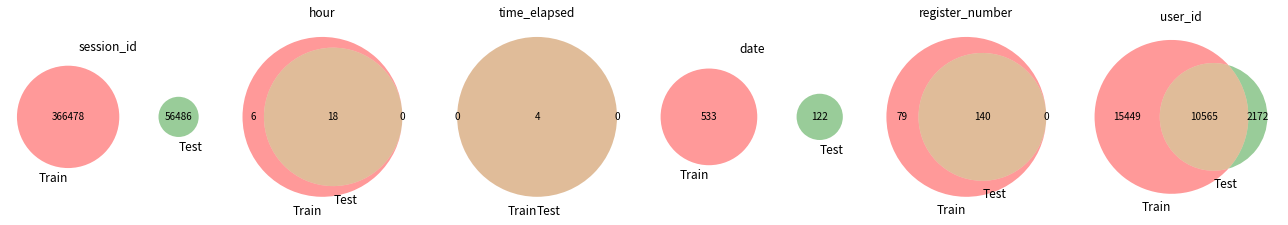

In [21]:
fig, _ = plot_right_left_inersection(train_meta_df, test_meta_df)
fig.tight_layout()

In [22]:
train_target_df, _  = create_target_from_log(train_private_df, 
                                             product_master_df=product_master_df,
                                            only_payment=False)

assert len(train_target_df) == len(train_meta_df)

366478


In [23]:
train_meta_df = pd.merge(train_meta_df, user_df, on='user_id', how='left')
test_meta_df = pd.merge(test_meta_df, user_df, on='user_id', how='left')

In [24]:
train_meta_df.head()

,session_id,time_elapsed,user_id,date,hour,register_number,age,gender
0,105,0,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,40.0,0.0
1,106,10,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,60.0,1.0
2,107,10,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,30.0,0.0
3,108,10,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,60.0,0.0
4,109,0,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,70.0,0.0


### 特徴量の作成

学習の枠組みが出来たので特徴量を作ります。前回は特徴量を作る関数を各々定義していました。こちらの方法でも良いのですが、内部状態が train フェーズで変化するような特徴量をつくるのにはあまり向いていません。例えば Target の情報を使って変換をする `TargetEncoding` などが該当します。

今回は特徴変換ごとにクラスを作り、内部状態をクラスのメンバー変数として管理する方法をご紹介できればと思います。

まずはじめに特徴変換一般に使うインターフェースを定義した `AbstractBaseBlock` を作成します。これは `fit` で学習 (すなわち内部状態の更新)を行ない `transform` で特徴への変換を行なう機能を備えています。`fit` では何もしない変換もありますので基本は `transform` 単体が呼び出されるようになっています。

In [25]:
class AbstractBaseBlock:
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()

#### 内部状態更新がおこなわれない例

入力される変換元のデータに含まれる情報を加工して取り出すような特徴量は内部状態が必要ありませんので `transform` のみを定義すればよいです。例えば `hour` をそのまま使う場合は単に `hour` を取り出す処理を行えば OK ですので内部状態は不要です。

In [26]:
class MetaInformationBlock(AbstractBaseBlock):
    def transform(self, input_df):
        use_columns = [
            'hour', 'register_number', 'time_elapsed', 'gender', 'age'
        ]
        return input_df[use_columns].copy()

In [27]:
MetaInformationBlock().fit(train_meta_df)

,hour,register_number,time_elapsed,gender,age
0,9,1005,0,0.0,40.0
1,9,1010,10,1.0,60.0
2,9,1010,10,0.0,30.0
3,9,1011,10,0.0,60.0
4,9,1013,0,0.0,70.0
...,...,...,...,...,...
366473,23,1018,5,1.0,40.0
366474,23,1028,3,1.0,30.0
366475,23,1058,10,0.0,50.0
366476,23,1076,3,0.0,20.0


`date` を変換するようなものも上記と同じ `transform` のみで実現できるものです。

In [28]:
class DateBlock(AbstractBaseBlock):
    def transform(self, input_df):
        date = pd.to_datetime(input_df['date'])
        
        out_df = pd.DataFrame({
            'dayofweek': date.dt.dayofweek,
            'day': date.dt.day,
            'month': date.dt.month,
            'year': date.dt.year
        })
        
        out_df['hanakin'] = np.where((date.dt.dayofweek == 4) & (input_df['hour'] > 16), 1, 0)
        
        return out_df.add_prefix('date_')

In [29]:
DateBlock().fit(train_meta_df)

,date_dayofweek,date_day,date_month,date_year,date_hanakin
0,3,14,2,2019,0
1,3,14,2,2019,0
2,3,14,2,2019,0
3,3,14,2,2019,0
4,3,14,2,2019,0
...,...,...,...,...,...
366473,4,31,7,2020,1
366474,4,31,7,2020,1
366475,4,31,7,2020,1
366476,4,31,7,2020,1


#### 内部状態変更が行われる例: CountEncoding

データの中で何回その値が出現するかに置き換える方法が CountEncoding です。例えば `[0, 0, 1, 0, 2]` という配列があったとすると `0` は3回, `1`, `2` は1回出現しますから `[3, 3, 1, 3, 1]` となります。このようにデータをその出てきた回数の観点で見るのが CountEncoding です。

CountEncoding は出現回数を数えるという内部状態の更新が必要ですので `fit` で回数を計算します。

In [30]:
class CountEncodingBlock(AbstractBaseBlock):
    """CountEncodingを行なう block"""
    def __init__(self, column: str):
        self.column = column
    
    def fit(self, input_df, y=None):
        vc = input_df[self.column].value_counts()
        self.count_ = vc
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].map(self.count_)
        return out_df.add_prefix('CE_')

In [31]:
CountEncodingBlock('register_number').fit(train_meta_df)

,CE_register_number
0,1860
1,2640
2,2640
3,2685
4,2788
...,...
366473,2901
366474,2137
366475,2593
366476,517


In [32]:
display_action_df = pd.read_csv(os.path.join(INPUT_DIR, 'display_action_id.csv'))
display_action2name = dict(zip(display_action_df['display_action_id'], display_action_df['display_name'] + '_' + display_action_df['action_name']))

In [33]:
class HourActionPortfolioBlock(AbstractBaseBlock):
    def fit(self, input_df, y=None):
        
        _df = pd.pivot_table(
            data=whole_log_df, 
            index='hour',
            columns=whole_log_df['display_action_id'],
            values='session_id',
            aggfunc='count'
        )
        
        _df = _df.div(_df.sum(axis=0), axis=1).fillna(0)
        self.pivot_df_ = _df
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.merge(input_df['hour'], self.pivot_df_, on='hour', how='left').drop(columns=['hour'])
        return out_df.add_prefix('hour_ratio=')

In [34]:
HourActionPortfolioBlock().fit(train_meta_df)

,hour_ratio=8,hour_ratio=9,hour_ratio=11,hour_ratio=14,hour_ratio=20,hour_ratio=22,hour_ratio=23,hour_ratio=25,hour_ratio=28,hour_ratio=36,...,hour_ratio=199,hour_ratio=202,hour_ratio=203,hour_ratio=204,hour_ratio=205,hour_ratio=207,hour_ratio=209,hour_ratio=216,hour_ratio=218,hour_ratio=225
0,0.047636,0.038392,0.044452,0.042889,0.027409,0.051504,0.012987,0.056140,0.033270,0.053611,...,0.035344,0.039617,0.046747,0.038660,0.050898,0.039062,0.044776,0.050147,0.036863,0.040824
1,0.047636,0.038392,0.044452,0.042889,0.027409,0.051504,0.012987,0.056140,0.033270,0.053611,...,0.035344,0.039617,0.046747,0.038660,0.050898,0.039062,0.044776,0.050147,0.036863,0.040824
2,0.047636,0.038392,0.044452,0.042889,0.027409,0.051504,0.012987,0.056140,0.033270,0.053611,...,0.035344,0.039617,0.046747,0.038660,0.050898,0.039062,0.044776,0.050147,0.036863,0.040824
3,0.047636,0.038392,0.044452,0.042889,0.027409,0.051504,0.012987,0.056140,0.033270,0.053611,...,0.035344,0.039617,0.046747,0.038660,0.050898,0.039062,0.044776,0.050147,0.036863,0.040824
4,0.047636,0.038392,0.044452,0.042889,0.027409,0.051504,0.012987,0.056140,0.033270,0.053611,...,0.035344,0.039617,0.046747,0.038660,0.050898,0.039062,0.044776,0.050147,0.036863,0.040824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366473,0.006106,0.005777,0.005523,0.002855,0.000825,0.002550,0.000000,0.004678,0.002677,0.003535,...,0.009975,0.000314,0.001263,0.005017,0.002994,0.008418,0.004985,0.002303,0.004298,0.001383
366474,0.006106,0.005777,0.005523,0.002855,0.000825,0.002550,0.000000,0.004678,0.002677,0.003535,...,0.009975,0.000314,0.001263,0.005017,0.002994,0.008418,0.004985,0.002303,0.004298,0.001383
366475,0.006106,0.005777,0.005523,0.002855,0.000825,0.002550,0.000000,0.004678,0.002677,0.003535,...,0.009975,0.000314,0.001263,0.005017,0.002994,0.008418,0.004985,0.002303,0.004298,0.001383
366476,0.006106,0.005777,0.005523,0.002855,0.000825,0.002550,0.000000,0.004678,0.002677,0.003535,...,0.009975,0.000314,0.001263,0.005017,0.002994,0.008418,0.004985,0.002303,0.004298,0.001383


In [35]:
def merge_and_fill_user_mean(input_df, agg_df, use_ratio=True):
        out_df = pd.merge(input_df['user_id'], agg_df, on='user_id', how='left')
        user_age_mean = pd.merge(agg_df, user_df, on='user_id', how='left').groupby(['gender', 'age']).mean()
        user_age_mean_df = \
            pd.merge(input_df['user_id'], user_df, on='user_id', how='left')\
            .merge(user_age_mean, on=['age', 'gender'], how='left')\
            .drop(columns=['age', 'gender'])
        
        assert out_df['user_id'].equals(user_age_mean_df['user_id'])
        
        out_df = out_df.combine_first(user_age_mean_df).drop(columns=['user_id'])
        
        if use_ratio:
            out_df = pd.concat([
                out_df,
#                 (out_df - user_age_mean_df.drop(columns=['user_id'])).add_prefix('diff_AGMean_'),
                (out_df / user_age_mean_df.drop(columns=['user_id'])).add_prefix('ratio_AGMean_')
            ], axis=1)
        
        return out_df

In [36]:
class UserCategoryHistoryBlock(AbstractBaseBlock):
    """ユーザーの購買履歴を部門名ごとに集計したベクトルを付与する特徴量 block"""
    
    def fit(self, input_df, y=None):
        purchase_df = only_purchase_records(whole_log_df)
        purchase_df = purchase_df.rename(columns={ 'value_1': 'JAN' })
        category = annot_category(purchase_df, product_master_df)
        idx_null = category.isnull()  # JAN が紐付かないやつ
        
        # target の情報はリークになる可能性があるので削除する
        idx_none_target = ~category.isin(TARGET_IDS)
        
        # 商品マスタの部門名を取り出して集計
        category_id = pd.merge(purchase_df['JAN'], product_master_df[['JAN', 'category_id']], on='JAN', how='left')['category_id']
        
        _df = pd.pivot_table(data=purchase_df[idx_none_target], 
               index='user_id', 
               columns=category_id[idx_none_target],
              values='n_items',
              aggfunc='sum')\
                .fillna(0)
        
        id2name = dict(zip(product_master_df['category_id'], product_master_df['category_name']))
        # ユーザーごとに平均化. 
        # _1個は買ったことがあるという事前情報をもたせる
        _df += 1
        _df = _df.div(_df.sum(axis=1), axis=0)
        _df.columns = _df.columns.map(id2name)
        
        self.agg_df_ = _df
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = merge_and_fill_user_mean(input_df, agg_df=self.agg_df_, use_ratio=False)
        return out_df.add_prefix('ratio_category=')

In [37]:
class UserHistoryBlock(AbstractBaseBlock):
    """ユーザーの購買履歴を部門名ごとに集計したベクトルを付与する特徴量 block"""
    
    def fit(self, input_df, y=None):
        purchase_df = only_purchase_records(whole_log_df)
        purchase_df = purchase_df.rename(columns={ 'value_1': 'JAN' })
        category = annot_category(purchase_df, product_master_df)
        idx_null = category.isnull()  # JAN が紐付かないやつ
        
        # target の情報はリークになる可能性があるので削除する
        idx_none_target = ~category.isin(TARGET_IDS)
        
        # 商品マスタの部門名を取り出して集計
        bumon_name = pd.merge(purchase_df['JAN'], product_master_df[['JAN', '部門名']], on='JAN', how='left')['部門名']
        
        _df = pd.pivot_table(data=purchase_df[idx_none_target], 
               index='user_id', 
               columns=bumon_name[idx_none_target],
              values='n_items',
              aggfunc='sum')\
                .fillna(0)
        
        # ユーザーごとに平均化. 
        _df += 1  # 1個は買ったことがあるという事前情報をもたせる
        _df = _df.div(_df.sum(axis=1), axis=0)
        
        self.agg_df_ = _df
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = merge_and_fill_user_mean(input_df, agg_df=self.agg_df_, use_ratio=True)
        return out_df.add_prefix('ratio_部門名=')

In [38]:
UserHistoryBlock().fit(train_meta_df)

,ratio_部門名=100円均一,ratio_部門名=AV家電,ratio_部門名=おもちゃ,ratio_部門名=たばこ,ratio_部門名=アイスクリーム,ratio_部門名=インテリア,ratio_部門名=オーラルケア,ratio_部門名=カスタマー,ratio_部門名=カー用品,ratio_部門名=キッズアウター,...,ratio_部門名=ratio_AGMean_調理家電,ratio_部門名=ratio_AGMean_調理素材,ratio_部門名=ratio_AGMean_豚肉,ratio_部門名=ratio_AGMean_軽家具・収納,ratio_部門名=ratio_AGMean_農産加工,ratio_部門名=ratio_AGMean_野菜,ratio_部門名=ratio_AGMean_釣具,ratio_部門名=ratio_AGMean_雑誌･CD,ratio_部門名=ratio_AGMean_鶏肉,ratio_部門名=ratio_AGMean_麺類
0,0.001370,0.000457,0.000457,0.000457,0.008680,0.002741,0.023755,0.000457,0.000457,0.000457,...,0.101624,2.300644,1.482956,0.100743,0.636786,1.885019,0.097011,0.101554,1.013374,2.109575
1,0.000571,0.000571,0.000571,0.001712,0.006849,0.001142,0.007991,0.000571,0.004566,0.000571,...,0.103495,1.513442,1.406228,0.205857,2.031128,2.074560,0.094857,0.104144,3.186122,0.988662
2,0.001613,0.001613,0.001613,0.001613,0.001613,0.001613,0.004839,0.001613,0.001613,0.003226,...,0.341740,1.709447,2.328353,0.339026,1.158404,1.574699,0.329939,0.686853,1.485759,1.698558
3,0.000958,0.000958,0.000958,0.000958,0.013410,0.000958,0.001916,0.000958,0.000958,0.000958,...,0.198794,0.848804,2.588515,0.195570,0.354145,1.164188,0.190249,0.199464,2.761228,0.680900
4,0.000747,0.000747,0.000747,0.000747,0.000747,0.000747,0.014200,0.000747,0.001495,0.000747,...,0.158662,1.855949,2.024752,0.158474,1.203728,1.784442,0.145239,0.159019,0.886685,1.824732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366473,0.001294,0.001294,0.001294,0.006468,0.001294,0.002587,0.015524,0.001294,0.002587,0.001294,...,0.239016,0.398356,0.564623,0.237153,0.816518,4.988287,0.219768,0.238879,1.045990,0.381217
366474,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999,0.012987,0.000999,0.000999,0.000999,...,0.180584,2.680469,4.870722,0.179651,1.301503,3.481508,0.170218,0.180708,5.818141,2.551955
366475,0.001946,0.001946,0.001946,0.001946,0.001946,0.003891,0.011673,0.001946,0.001946,0.001946,...,0.401536,1.879362,0.265716,0.396645,3.119242,1.178659,0.396336,0.401611,0.799991,2.366754
366476,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,...,1.372910,0.715970,0.579443,1.341023,0.559023,0.204292,1.347590,1.381394,0.630578,0.788463


In [39]:
class ShoppingActionBlock(AbstractBaseBlock):
    def fit(self, input_df, y=None):
        purchase_df = only_purchase_records(whole_log_df)
        _df = pd.pivot_table(data=purchase_df, 
               index='user_id', 
               columns='display_action_id',
              values='session_id',
              aggfunc='count')\
                .fillna(0)

        n_shopping = purchase_df.groupby('user_id')['session_id'].nunique()
        _df = _df.div(n_shopping, axis=0)
        _df.columns = _df.columns.map(display_action2name)
        self.agg_df_ = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = merge_and_fill_user_mean(input_df, agg_df=self.agg_df_, use_ratio=False)
        return out_df.add_prefix('UserActionRatio=')

In [40]:
class UserShoppingTimeBlock(AbstractBaseBlock):
    """ユーザーごとのお買い物時間の特徴量. 買物時間が長い=非計画購買が多い可能性が高いのでそういう情報を取り出したいという気持ち.
    
    - 買物完了したレコードに対して
    - セッションごとの最大時間 (これを買物の時間と定義) を計算して
    - ユーザーに紐づくセッションの平均・最大・最小・分散を計算
    """
    def fit(self, input_df, y=None):
        self.user_session_df_ = pd.merge(payment_session_df[['session_id', 'user_id']], 
                                          whole_log_df.groupby('session_id')['spend_time'].max(), 
                                          on='session_id', how='left')\
            .groupby('user_id')['spend_time'].agg(['min', 'max', 'mean', 'std'])
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = merge_and_fill_user_mean(input_df=input_df, agg_df=self.user_session_df_)
        out_df = pd.concat([
            out_df, out_df[['min', 'max', 'mean']].sub(input_df['time_elapsed'].values * 60, axis=0).add_suffix('_minus_time_elapsed')
        ], axis=1)
        return out_df.add_prefix('user_session_spend_time=')

In [41]:
block = UserShoppingTimeBlock()
block.fit(train_meta_df)

,user_session_spend_time=min,user_session_spend_time=max,user_session_spend_time=mean,user_session_spend_time=std,user_session_spend_time=ratio_AGMean_min,user_session_spend_time=ratio_AGMean_max,user_session_spend_time=ratio_AGMean_mean,user_session_spend_time=ratio_AGMean_std,user_session_spend_time=min_minus_time_elapsed,user_session_spend_time=max_minus_time_elapsed,user_session_spend_time=mean_minus_time_elapsed
0,47,5012,2472.398635,1019.040389,0.081664,1.461738,1.776622,1.931759,47,5012,2472.398635
1,12,3771,1344.402324,525.531021,0.029289,1.712811,1.540151,1.409881,-588,3171,744.402324
2,51,1881,961.065327,490.194410,0.080424,0.504584,0.687236,0.907719,-549,1281,361.065327
3,14,2321,326.177089,487.010474,0.023618,0.454061,0.234087,0.661536,-586,1721,-273.822911
4,19,2744,792.603476,305.813314,0.032758,0.680272,0.553837,0.484348,19,2744,792.603476
...,...,...,...,...,...,...,...,...,...,...,...
366473,66,3014,1081.871192,533.692757,0.132086,1.180881,1.036111,1.307890,-234,2714,781.871192
366474,142,2797,1767.988267,544.954223,0.268981,0.921369,1.641160,1.215925,-38,2617,1587.988267
366475,19,3256,1344.112474,722.483164,0.031007,0.937172,0.966312,1.349240,-581,2656,744.112474
366476,1007,1007,1007.000000,0.000000,1.424898,0.442369,0.778993,0.000000,827,827,827.000000


In [42]:
class PublicLogBlock(AbstractBaseBlock):
    def fit(self, input_df, y=None):
        self.agg_df_ = pd.concat([
            public_log_df.groupby('session_id')['n_items'].sum().rename('total_items'),
            public_log_df[public_log_df['kind_1'] == '商品'].groupby('session_id')['value_1'].nunique().rename('JAN_nunique')
        ], axis=1)
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.merge(input_df['session_id'], self.agg_df_, on='session_id', how='left').drop(columns=['session_id'])
        out_df = out_df.fillna(0)
        return out_df.add_prefix('public_log=')

In [43]:
class PublicLogCategoryBlock(AbstractBaseBlock):
    def fit(self, input_df, y=None):
            _df = public_log_df[['session_id', 'value_1', 'n_items']].copy()
            _df['category_id'] = annot_category(_df, master_df=product_master_df)
            self.agg_df_ = pd.pivot_table(
                data=_df, 
                columns='category_id', 
                index='session_id', 
                values='n_items', 
                aggfunc='sum').fillna(0)
            
            category_id2name = dict(zip(product_master_df['category_id'], product_master_df['category_name']))
            self.agg_df_.columns = self.agg_df_.columns.map(category_id2name)
            return self.transform(input_df)
        
    def transform(self, input_df):
        out_df = pd.merge(input_df['session_id'], self.agg_df_, on='session_id', how='left').drop(columns=['session_id'])
        out_df = out_df.fillna(0)
        return out_df.add_prefix('PublicLog_category-sum=')

In [44]:
class UserKindProfileBlock(AbstractBaseBlock):
    def fit(self, input_df, y=None):
        _df = pd.pivot_table(data=whole_log_df,
                      index='user_id',
                      columns='kind_1',
                      values='session_id',
                      aggfunc='count').fillna(0)

        n_shopping = whole_log_df.groupby('user_id')['session_id'].nunique()
        _df = _df.div(n_shopping, axis=0)

        self.agg_df_ = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = merge_and_fill_user_mean(input_df=input_df, agg_df=self.agg_df_)
        return out_df.add_prefix('user_kind_')

In [45]:
meta_df['date'] = pd.to_datetime(meta_df['date'])

In [46]:
class UserShoppingIntervalBlock(AbstractBaseBlock):
    def _get_metadata(self):
        return meta_df
    
    def fit(self, input_df, y=None):
        df = meta_df[['session_id', 'user_id']].copy()
        days = (meta_df['date'] - meta_df.groupby('user_id')['date'].shift(1)).dt.days
        df['before_one_shopping'] = days
        x = df.groupby('user_id')['before_one_shopping'].mean().rename('user_mean_shopping_interval')
        x = x.fillna(x.mean())
        df = pd.concat([df, pd.merge(df['user_id'], x, on='user_id', how='left')['user_mean_shopping_interval']], axis=1)
        self.agg_df_ = df.drop(columns=['user_id'])
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.merge(input_df['session_id'], 
                          self.agg_df_, 
                          on='session_id', 
                          how='left').drop(columns=['session_id']).fillna(0)
        return out_df.add_prefix('USINT_')

In [47]:
class BeforeBuyIntervalBlock(AbstractBaseBlock):
    def __init__(self, category_id):
        self.category_id = category_id

    def fit(self, input_df, y=None):
        log_df = pd.concat([public_log_df, whole_log_df], ignore_index=True)
        jans = product_master_df[product_master_df['category_id'] == self.category_id]['JAN'].unique()
        x = log_df[(log_df['kind_1'] == '商品') & (log_df['value_1'].isin(jans))].groupby('session_id')['n_items'].sum()

        buy_sessions = x[x > 0].index
        df = meta_df[['session_id', 'user_id', 'date']].copy()

        df['buy'] = df['session_id'].isin(buy_sessions).astype(int)
        out_df = pd.DataFrame()

        # 過去平均何回買っているか
        df['past_avg_buy'] = (df.groupby('user_id')['buy'].cumsum() - df['buy']) / (df.groupby('user_id').cumcount() + 1)

        # 直前買ってから何日か
        _x = pd.concat([
            df[['user_id', 'date']],
            (df.groupby('user_id')['buy'].cumsum() - df['buy'])
        ], axis=1)
        _x = _x.merge(_x.groupby(['user_id', 'buy'])['date'].first().rename('first_date'), on=['user_id', 'buy'], how='left')
        _x = _x.merge(_x.groupby('user_id')['date'].first().rename('user_first_date'), on='user_id', how='left')
        from_before_buy = np.where(_x['first_date'] == _x['user_first_date'], None, (_x['date'] - _x['first_date']).dt.days)
        df['days_before_buy'] = from_before_buy
        self.agg_df_ = df
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.merge(input_df['session_id'], 
                          self.agg_df_, 
                          on='session_id', 
                          how='left').drop(columns=['session_id', 'user_id', 'date', 'buy'])
        return out_df.add_prefix('BBInterval_{}_'.format(self.category_id))

In [48]:
block = BeforeBuyIntervalBlock(171)

In [49]:
block.fit(train_meta_df)

,BBInterval_171_past_avg_buy,BBInterval_171_days_before_buy
0,0.000000,None
1,0.000000,None
2,0.000000,None
3,0.000000,None
4,0.000000,None
...,...,...
366473,0.196078,43
366474,0.151515,0
366475,0.151163,62
366476,0.000000,None


In [50]:
block.transform(test_meta_df)

,BBInterval_171_past_avg_buy,BBInterval_171_days_before_buy
0,0.041322,269
1,0.015152,355
2,0.225806,176
3,0.669492,7
4,0.057143,14
...,...,...
56481,0.000000,None
56482,0.017621,133
56483,0.000000,None
56484,0.000000,None


### 特徴量への変換

定義した `Block` を使って特徴量を作っていきます。はじめに `feature_blocks` で使う Block を定義。次に `block.fit` で内部状態の変換と学習時に使う特徴量の作成、最後に `block.transform` でテスト時の特徴を作成しています。

In [51]:
from tqdm.notebook import tqdm

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    dfs = []
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dfs.append(df[col].astype(np.int8))
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dfs.append(df[col].astype(np.int16))
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dfs.append(df[col].astype(np.int32))
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dfs.append(df[col].astype(np.int64) ) 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dfs.append(df[col].astype(np.float16))
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dfs.append(df[col].astype(np.float32))
                else:
                    dfs.append(df[col].astype(np.float64))
        else:
            dfs.append(df[col])
    
    df_out = pd.concat(dfs, axis=1)
    if verbose:
        end_mem = df_out.memory_usage().sum() / 1024**2
        num_reduction = str(100 * (start_mem - end_mem) / start_mem)
        logger.info(f'Mem. usage decreased to {str(end_mem)[:3]}Mb:  {num_reduction[:2]}% reduction')
    return df_out

In [52]:
feature_blocks = [
    *[CountEncodingBlock(column=c) for c in ['register_number', 'hour', 'gender', 'age']],
    DateBlock(),
    PublicLogBlock(),
    MetaInformationBlock(),
    UserHistoryBlock(),
    UserShoppingTimeBlock(),
    ShoppingActionBlock(),
    UserKindProfileBlock(),
    UserCategoryHistoryBlock(),
    PublicLogCategoryBlock(),
    UserShoppingIntervalBlock(),
    *[BeforeBuyIntervalBlock(i) for i in TARGET_IDS]
]

feat_train_df = pd.DataFrame()

for block in feature_blocks:
    with timer(logger, prefix='fit {} '.format(block)):
        out_i = block.fit(train_meta_df)
    assert len(train_meta_df) == len(out_i), block
    out_i = reduce_mem_usage(out_i)
    feat_train_df = pd.concat([feat_train_df, out_i], axis=1)

0008__exp                     : INFO     fit <__main__.CountEncodingBlock object at 0x7f8bffc26150> 0.060[s]
0008__exp                     : INFO     Mem. usage decreased to 3.4Mb:  37% reduction
0008__exp                     : INFO     fit <__main__.CountEncodingBlock object at 0x7f8bffc262d0> 0.034[s]
0008__exp                     : INFO     Mem. usage decreased to 4.1Mb:  25% reduction
0008__exp                     : INFO     fit <__main__.CountEncodingBlock object at 0x7f8bffc26210> 0.037[s]
0008__exp                     : INFO     Mem. usage decreased to 4.1Mb:  25% reduction
0008__exp                     : INFO     fit <__main__.CountEncodingBlock object at 0x7f8bffc26390> 0.040[s]
0008__exp                     : INFO     Mem. usage decreased to 4.1Mb:  25% reduction
0008__exp                     : INFO     fit <__main__.DateBlock object at 0x7f8bffc268d0> 0.131[s]
0008__exp                     : INFO     Mem. usage decreased to 4.8Mb:  70% reduction
0008__exp                    

In [53]:
del public_log_df
del whole_log_df

gc.collect()

42

In [54]:
feat_test_df = pd.DataFrame()

for block in feature_blocks:
    with timer(logger, prefix='transform {} '.format(block)):
        out_i = block.transform(test_meta_df)

    assert len(test_meta_df) == len(out_i), block
    feat_test_df = pd.concat([feat_test_df, out_i], axis=1)

0008__exp                     : INFO     transform <__main__.CountEncodingBlock object at 0x7f8bffc26150> 0.036[s]
0008__exp                     : INFO     transform <__main__.CountEncodingBlock object at 0x7f8bffc262d0> 0.013[s]
0008__exp                     : INFO     transform <__main__.CountEncodingBlock object at 0x7f8bffc26210> 0.009[s]
0008__exp                     : INFO     transform <__main__.CountEncodingBlock object at 0x7f8bffc26390> 0.008[s]
0008__exp                     : INFO     transform <__main__.DateBlock object at 0x7f8bffc268d0> 0.023[s]
0008__exp                     : INFO     transform <__main__.PublicLogBlock object at 0x7f8bffc26d50> 0.036[s]
0008__exp                     : INFO     transform <__main__.MetaInformationBlock object at 0x7f8bffc26710> 0.002[s]
0008__exp                     : INFO     transform <__main__.UserHistoryBlock object at 0x7f8bffc26fd0> 0.337[s]
0008__exp                     : INFO     transform <__main__.UserShoppingTimeBlock object at 

In [55]:
del feature_blocks
gc.collect()

20

In [56]:
import joblib

In [57]:
with timer(prefix='save train target '):
    train_target_df.to_csv(os.path.join(OUTPUT_DIR, 'target.csv'), index=False)

save train target 0.936[s]


In [58]:
feat_test_df = reduce_mem_usage(feat_test_df)

0008__exp                     : INFO     Mem. usage decreased to 187Mb:  74% reduction


In [59]:
gc.collect()

20

In [60]:
feat_train_df.shape

(366478, 1682)

In [61]:
feat_test_df.shape

(56486, 1682)

In [62]:
with timer(logger, prefix='save train feature '):
    joblib.dump(feat_train_df, os.path.join(OUTPUT_DIR, 'train_feature.joblib'))

with timer(logger, prefix='save test feature '):
    joblib.dump(feat_test_df, os.path.join(OUTPUT_DIR, 'test_feature.joblib'))

0008__exp                     : INFO     save train feature 1.492[s]
0008__exp                     : INFO     save test feature 0.241[s]


In [63]:
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from copy import deepcopy

LGBM_DEFAULT_PARAMS = {
    'objective': 'binary',
    'learning_rate': .05,
    'max_depth': 6,
    'n_estimators': 10000,
    'colsample_bytree': .5,
    'importance_type': 'gain',
    'reg_lambda': .1,
    'bagging_freq': 3,
    'bagging_fraction': .7
}

def fit_lgbm(X, y, cv=None, params: dict=None, verbose=100):

    # パラメータがないときはデフォルトパラメータを使う
    if params is None:
        params = deepcopy(LGBM_DEFAULT_PARAMS)

    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)
    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv.split(X, y)): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=200, 
                eval_metric='logloss',
                verbose=verbose)

        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        logger.info(f'Fold {i} AUC: {roc_auc_score(y_valid, pred_i):.4f}')

    score = roc_auc_score(y, oof_pred)
    logger.info('FINISHED \ whole AUC: {:.4f}'.format(score))
    return oof_pred, models

def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', 
                  orient='h',
                  order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax


def create_predict(models, input_df) -> np.ndarray:
    """与えられた機械学習モデルで予測する"""
    pred = np.array([model.predict_proba(input_df.values)[:, 1] for model in models])
    pred = np.mean(pred, axis=0)
    return pred

def fit_and_predict(train_df, 
                    target_df, 
                    target_id):
    """対象の target_id の学習を行なう"""
    target_name = category_id2code[target_id]
    
    logger.info('-' * 20 + ' start {} '.format(target_name) + '-' * 20)
    
    if target_id not in TARGET_IDS:
        raise ValueError('`target_id` は {} から選んでください'.format(','.join(str, TARGET_IDS)))
    
    y = target_df[target_id].values
    y = np.where(y > 0, 1, 0)
    
    # モデルの学習.
    oof, models = fit_lgbm(train_df.values, y, verbose=500)
    
    # 特徴重要度の可視化
    fig, ax = visualize_importance(models, train_df)
    ax.set_title('Importance: TARGET={}'.format(target_name))
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, f'{target_name}_importance.png'))
    plt.close(fig)
    return oof, models

In [64]:
oof_df, pred_df = pd.DataFrame(), pd.DataFrame()

for i in TARGET_IDS:
    target_name = category_id2code[i]
    with timer(logger=logger, prefix='train {} '.format(target_name)):
        oof, models = fit_and_predict(train_df=feat_train_df, 
                                    target_df=train_target_df,
                                    target_id=i)
    
    # 予測モデルで推論実行
    with timer(logger, prefix='predict {} '.format(target_name)):
        pred = create_predict(models, input_df=feat_test_df)
    
    oof_df[i] = oof
    pred_df[i] = pred

0008__exp                     : INFO     -------------------- start ビール系__RTD --------------------


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.211757
[1000]	valid_0's binary_logloss: 0.211475
Early stopping, best iteration is:
[910]	valid_0's binary_logloss: 0.21139


0008__exp                     : INFO     Fold 0 AUC: 0.8662


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.210551
[1000]	valid_0's binary_logloss: 0.209963
Early stopping, best iteration is:
[878]	valid_0's binary_logloss: 0.209912


0008__exp                     : INFO     Fold 1 AUC: 0.8674


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.214509
[1000]	valid_0's binary_logloss: 0.214295
Early stopping, best iteration is:
[826]	valid_0's binary_logloss: 0.214114


0008__exp                     : INFO     Fold 2 AUC: 0.8619


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.213401
[1000]	valid_0's binary_logloss: 0.213004
Early stopping, best iteration is:
[973]	valid_0's binary_logloss: 0.212919


0008__exp                     : INFO     Fold 3 AUC: 0.8627


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.209465
[1000]	valid_0's binary_logloss: 0.209448
Early stopping, best iteration is:
[807]	valid_0's binary_logloss: 0.209299


0008__exp                     : INFO     Fold 4 AUC: 0.8679
0008__exp                     : INFO     FINISHED \ whole AUC: 0.8652
0008__exp                     : INFO     train ビール系__RTD 785.807[s]
0008__exp                     : INFO     predict ビール系__RTD 39.173[s]
0008__exp                     : INFO     -------------------- start ビール系__ビール系 --------------------


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.232349
[1000]	valid_0's binary_logloss: 0.231953
Early stopping, best iteration is:
[923]	valid_0's binary_logloss: 0.231865


0008__exp                     : INFO     Fold 0 AUC: 0.8619


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.230449
Early stopping, best iteration is:
[627]	valid_0's binary_logloss: 0.230275


0008__exp                     : INFO     Fold 1 AUC: 0.8641


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.233317
Early stopping, best iteration is:
[660]	valid_0's binary_logloss: 0.233087


0008__exp                     : INFO     Fold 2 AUC: 0.8613


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.232344
[1000]	valid_0's binary_logloss: 0.231909
Early stopping, best iteration is:
[829]	valid_0's binary_logloss: 0.231815


0008__exp                     : INFO     Fold 3 AUC: 0.8628


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.231959
[1000]	valid_0's binary_logloss: 0.231627
Early stopping, best iteration is:
[895]	valid_0's binary_logloss: 0.23157


0008__exp                     : INFO     Fold 4 AUC: 0.8630
0008__exp                     : INFO     FINISHED \ whole AUC: 0.8626
0008__exp                     : INFO     train ビール系__ビール系 770.715[s]
0008__exp                     : INFO     predict ビール系__ビール系 38.885[s]
0008__exp                     : INFO     -------------------- start ビール系__ノンアルコール --------------------


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[269]	valid_0's binary_logloss: 0.0709951


0008__exp                     : INFO     Fold 0 AUC: 0.8674


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.0709267
Early stopping, best iteration is:
[308]	valid_0's binary_logloss: 0.0707568


0008__exp                     : INFO     Fold 1 AUC: 0.8713


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.0711943


0008__exp                     : INFO     Fold 2 AUC: 0.8690


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.0703449
Early stopping, best iteration is:
[512]	valid_0's binary_logloss: 0.0703218


0008__exp                     : INFO     Fold 3 AUC: 0.8682


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.0713967
Early stopping, best iteration is:
[389]	valid_0's binary_logloss: 0.0712517


0008__exp                     : INFO     Fold 4 AUC: 0.8650
0008__exp                     : INFO     FINISHED \ whole AUC: 0.8679
0008__exp                     : INFO     train ビール系__ノンアルコール 593.226[s]
0008__exp                     : INFO     predict ビール系__ノンアルコール 38.397[s]
0008__exp                     : INFO     -------------------- start スナック・キャンディー__スナック --------------------


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.434921
Early stopping, best iteration is:
[738]	valid_0's binary_logloss: 0.434466


0008__exp                     : INFO     Fold 0 AUC: 0.7611


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.432454
[1000]	valid_0's binary_logloss: 0.431836
Early stopping, best iteration is:
[947]	valid_0's binary_logloss: 0.431743


0008__exp                     : INFO     Fold 1 AUC: 0.7650


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.43338
[1000]	valid_0's binary_logloss: 0.433149
Early stopping, best iteration is:
[836]	valid_0's binary_logloss: 0.433098


0008__exp                     : INFO     Fold 2 AUC: 0.7624


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.435156
Early stopping, best iteration is:
[740]	valid_0's binary_logloss: 0.434773


0008__exp                     : INFO     Fold 3 AUC: 0.7604


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.432879
[1000]	valid_0's binary_logloss: 0.432294
Early stopping, best iteration is:
[1091]	valid_0's binary_logloss: 0.432145


0008__exp                     : INFO     Fold 4 AUC: 0.7652
0008__exp                     : INFO     FINISHED \ whole AUC: 0.7628
0008__exp                     : INFO     train スナック・キャンディー__スナック 782.914[s]
0008__exp                     : INFO     predict スナック・キャンディー__スナック 39.168[s]
0008__exp                     : INFO     -------------------- start チョコ・ビスクラ__チョコレート --------------------


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.355496
Early stopping, best iteration is:
[579]	valid_0's binary_logloss: 0.355357


0008__exp                     : INFO     Fold 0 AUC: 0.7490


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.354261
Early stopping, best iteration is:
[557]	valid_0's binary_logloss: 0.354185


0008__exp                     : INFO     Fold 1 AUC: 0.7527


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.355879
Early stopping, best iteration is:
[525]	valid_0's binary_logloss: 0.355797


0008__exp                     : INFO     Fold 2 AUC: 0.7496


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.353376
Early stopping, best iteration is:
[679]	valid_0's binary_logloss: 0.353305


0008__exp                     : INFO     Fold 3 AUC: 0.7543


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.355724
Early stopping, best iteration is:
[618]	valid_0's binary_logloss: 0.355522


0008__exp                     : INFO     Fold 4 AUC: 0.7502
0008__exp                     : INFO     FINISHED \ whole AUC: 0.7511
0008__exp                     : INFO     train チョコ・ビスクラ__チョコレート 687.775[s]
0008__exp                     : INFO     predict チョコ・ビスクラ__チョコレート 38.946[s]
0008__exp                     : INFO     -------------------- start スナック・キャンディー__ガム --------------------


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.0649097


0008__exp                     : INFO     Fold 0 AUC: 0.7989


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.064766


0008__exp                     : INFO     Fold 1 AUC: 0.8042


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.065547


0008__exp                     : INFO     Fold 2 AUC: 0.7969


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0655671


0008__exp                     : INFO     Fold 3 AUC: 0.7982


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.0649085


0008__exp                     : INFO     Fold 4 AUC: 0.7981
0008__exp                     : INFO     FINISHED \ whole AUC: 0.7991
0008__exp                     : INFO     train スナック・キャンディー__ガム 517.285[s]
0008__exp                     : INFO     predict スナック・キャンディー__ガム 38.057[s]
0008__exp                     : INFO     -------------------- start スナック・キャンディー__シリアル --------------------


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[269]	valid_0's binary_logloss: 0.133494


0008__exp                     : INFO     Fold 0 AUC: 0.8131


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.134455
Early stopping, best iteration is:
[413]	valid_0's binary_logloss: 0.134207


0008__exp                     : INFO     Fold 1 AUC: 0.8082


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.133991
Early stopping, best iteration is:
[365]	valid_0's binary_logloss: 0.133811


0008__exp                     : INFO     Fold 2 AUC: 0.8089


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.133574
Early stopping, best iteration is:
[337]	valid_0's binary_logloss: 0.133479


0008__exp                     : INFO     Fold 3 AUC: 0.8132


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.133214
Early stopping, best iteration is:
[380]	valid_0's binary_logloss: 0.133042


0008__exp                     : INFO     Fold 4 AUC: 0.8137
0008__exp                     : INFO     FINISHED \ whole AUC: 0.8113
0008__exp                     : INFO     train スナック・キャンディー__シリアル 596.268[s]
0008__exp                     : INFO     predict スナック・キャンディー__シリアル 38.324[s]
0008__exp                     : INFO     -------------------- start アイスクリーム__ノベルティー --------------------


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.219444
Early stopping, best iteration is:
[462]	valid_0's binary_logloss: 0.219392


0008__exp                     : INFO     Fold 0 AUC: 0.8243


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.215735
[1000]	valid_0's binary_logloss: 0.215561
Early stopping, best iteration is:
[858]	valid_0's binary_logloss: 0.215481


0008__exp                     : INFO     Fold 1 AUC: 0.8321


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.217383
Early stopping, best iteration is:
[524]	valid_0's binary_logloss: 0.217297


0008__exp                     : INFO     Fold 2 AUC: 0.8278


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.216865
Early stopping, best iteration is:
[630]	valid_0's binary_logloss: 0.21681


0008__exp                     : INFO     Fold 3 AUC: 0.8306


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.218207
Early stopping, best iteration is:
[504]	valid_0's binary_logloss: 0.218184


0008__exp                     : INFO     Fold 4 AUC: 0.8259
0008__exp                     : INFO     FINISHED \ whole AUC: 0.8282
0008__exp                     : INFO     train アイスクリーム__ノベルティー 689.206[s]
0008__exp                     : INFO     predict アイスクリーム__ノベルティー 39.007[s]
0008__exp                     : INFO     -------------------- start 和菓子__米菓 --------------------


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.262077
Early stopping, best iteration is:
[704]	valid_0's binary_logloss: 0.261951


0008__exp                     : INFO     Fold 0 AUC: 0.7627


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.260255
Early stopping, best iteration is:
[556]	valid_0's binary_logloss: 0.260208


0008__exp                     : INFO     Fold 1 AUC: 0.7686


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.261734
Early stopping, best iteration is:
[337]	valid_0's binary_logloss: 0.261621


0008__exp                     : INFO     Fold 2 AUC: 0.7652


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.261547
Early stopping, best iteration is:
[400]	valid_0's binary_logloss: 0.261376


0008__exp                     : INFO     Fold 3 AUC: 0.7648


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.262998
Early stopping, best iteration is:
[473]	valid_0's binary_logloss: 0.262954


0008__exp                     : INFO     Fold 4 AUC: 0.7614
0008__exp                     : INFO     FINISHED \ whole AUC: 0.7645
0008__exp                     : INFO     train 和菓子__米菓 670.243[s]
0008__exp                     : INFO     predict 和菓子__米菓 39.078[s]
0008__exp                     : INFO     -------------------- start 水・炭酸水__大型PET（炭酸水） --------------------


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.0819207
Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.0817401


0008__exp                     : INFO     Fold 0 AUC: 0.9023


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.0820055
Early stopping, best iteration is:
[366]	valid_0's binary_logloss: 0.0819721


0008__exp                     : INFO     Fold 1 AUC: 0.9026


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.0815098
Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.081445


0008__exp                     : INFO     Fold 2 AUC: 0.9034


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.081842


0008__exp                     : INFO     Fold 3 AUC: 0.9037


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 0.0824387


0008__exp                     : INFO     Fold 4 AUC: 0.9025
0008__exp                     : INFO     FINISHED \ whole AUC: 0.9028
0008__exp                     : INFO     train 水・炭酸水__大型PET（炭酸水） 613.650[s]
0008__exp                     : INFO     predict 水・炭酸水__大型PET（炭酸水） 40.808[s]
0008__exp                     : INFO     -------------------- start 水・炭酸水__小型PET（炭酸水） --------------------


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.11717
Early stopping, best iteration is:
[384]	valid_0's binary_logloss: 0.116944


0008__exp                     : INFO     Fold 0 AUC: 0.8603


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.117849
Early stopping, best iteration is:
[441]	valid_0's binary_logloss: 0.117799


0008__exp                     : INFO     Fold 1 AUC: 0.8531


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.116185
Early stopping, best iteration is:
[368]	valid_0's binary_logloss: 0.116048


0008__exp                     : INFO     Fold 2 AUC: 0.8623


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[276]	valid_0's binary_logloss: 0.117933


0008__exp                     : INFO     Fold 3 AUC: 0.8522


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.118797


0008__exp                     : INFO     Fold 4 AUC: 0.8524
0008__exp                     : INFO     FINISHED \ whole AUC: 0.8560
0008__exp                     : INFO     train 水・炭酸水__小型PET（炭酸水） 607.329[s]
0008__exp                     : INFO     predict 水・炭酸水__小型PET（炭酸水） 38.610[s]
0008__exp                     : INFO     -------------------- start 缶飲料__コーヒー（缶） --------------------


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.0370456


0008__exp                     : INFO     Fold 0 AUC: 0.9188


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[294]	valid_0's binary_logloss: 0.0363986


0008__exp                     : INFO     Fold 1 AUC: 0.9216


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.0367938


0008__exp                     : INFO     Fold 2 AUC: 0.9191


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.0378371


0008__exp                     : INFO     Fold 3 AUC: 0.9085


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.0365757
Early stopping, best iteration is:
[338]	valid_0's binary_logloss: 0.0365393


0008__exp                     : INFO     Fold 4 AUC: 0.9160
0008__exp                     : INFO     FINISHED \ whole AUC: 0.9164
0008__exp                     : INFO     train 缶飲料__コーヒー（缶） 547.142[s]
0008__exp                     : INFO     predict 缶飲料__コーヒー（缶） 38.242[s]
0008__exp                     : INFO     -------------------- start 小型PET__コーヒー（小型PET） --------------------


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 0.0803847


0008__exp                     : INFO     Fold 0 AUC: 0.8702


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.0823325


0008__exp                     : INFO     Fold 1 AUC: 0.8611


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.0795912
Early stopping, best iteration is:
[318]	valid_0's binary_logloss: 0.0794139


0008__exp                     : INFO     Fold 2 AUC: 0.8773


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.0818174


0008__exp                     : INFO     Fold 3 AUC: 0.8633


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.0805859


0008__exp                     : INFO     Fold 4 AUC: 0.8718
0008__exp                     : INFO     FINISHED \ whole AUC: 0.8688
0008__exp                     : INFO     train 小型PET__コーヒー（小型PET） 565.513[s]
0008__exp                     : INFO     predict 小型PET__コーヒー（小型PET） 38.673[s]
0008__exp                     : INFO     -------------------- start 大型PET__無糖茶（大型PET） --------------------


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.139665
Early stopping, best iteration is:
[565]	valid_0's binary_logloss: 0.139587


0008__exp                     : INFO     Fold 0 AUC: 0.8690


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.141756
Early stopping, best iteration is:
[560]	valid_0's binary_logloss: 0.141715


0008__exp                     : INFO     Fold 1 AUC: 0.8637


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.142445
Early stopping, best iteration is:
[447]	valid_0's binary_logloss: 0.142354


0008__exp                     : INFO     Fold 2 AUC: 0.8627


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.139379
Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 0.139258


0008__exp                     : INFO     Fold 3 AUC: 0.8719


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.140624
Early stopping, best iteration is:
[521]	valid_0's binary_logloss: 0.140588


0008__exp                     : INFO     Fold 4 AUC: 0.8684
0008__exp                     : INFO     FINISHED \ whole AUC: 0.8670
0008__exp                     : INFO     train 大型PET__無糖茶（大型PET） 650.998[s]
0008__exp                     : INFO     predict 大型PET__無糖茶（大型PET） 38.686[s]
0008__exp                     : INFO     -------------------- start 麺類__カップ麺 --------------------


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.291323
Early stopping, best iteration is:
[596]	valid_0's binary_logloss: 0.291147


0008__exp                     : INFO     Fold 0 AUC: 0.7518


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.291977
Early stopping, best iteration is:
[483]	valid_0's binary_logloss: 0.291948


0008__exp                     : INFO     Fold 1 AUC: 0.7491


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.291876
Early stopping, best iteration is:
[494]	valid_0's binary_logloss: 0.291871


0008__exp                     : INFO     Fold 2 AUC: 0.7500


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.291999
Early stopping, best iteration is:
[690]	valid_0's binary_logloss: 0.291853


0008__exp                     : INFO     Fold 3 AUC: 0.7506


Training until validation scores don't improve for 200 rounds
[500]	valid_0's binary_logloss: 0.290593
Early stopping, best iteration is:
[661]	valid_0's binary_logloss: 0.290506


0008__exp                     : INFO     Fold 4 AUC: 0.7525
0008__exp                     : INFO     FINISHED \ whole AUC: 0.7508
0008__exp                     : INFO     train 麺類__カップ麺 685.341[s]
0008__exp                     : INFO     predict 麺類__カップ麺 39.648[s]


In [65]:
oof_score = roc_auc_score((train_target_df[TARGET_IDS] > 0).astype(int), oof_df[TARGET_IDS], average='macro')

logger.info('Out-Of-Fold Score: {:.4f}'.format(oof_score))

0008__exp                     : INFO     Out-Of-Fold Score: 0.8316


In [66]:
nfigs = len(oof_df.columns)
ncols = 5
nrows = - (- nfigs // ncols)
fig, axes = plt.subplots(figsize=(5 * ncols, 3 * nrows), ncols=ncols, nrows=nrows, sharex=True)
axes = np.ravel(axes)

with timer(prefix='plot oof-test-distributions '):
    for c, ax in zip(oof_df.columns, axes):
        sns.histplot(data=pd.DataFrame({
            'OOF': oof_df[c],
            'Test': pred_df[c]
        }), ax=ax, stat='density', common_norm=False,)
        ax.set_title(category_id2code[c])
        ax.grid()
    fig.tight_layout()
    savefig(fig, to='out-of-fold_vs_test')

plot oof-test-distributions 88.134[s]


In [67]:
pred_df.to_csv(os.path.join(OUTPUT_DIR, f'{filename}_submission.csv'), index=False)

In [68]:
!pip install sweetviz

You should consider upgrading via the '/home/penguin/.conda/bin/python -m pip install --upgrade pip' command.


In [69]:
import sweetviz as sv

# 日本語化の設定
vis_conf = """[General]
use_cjk_font = 1 
"""

vis_config_path = "./sweetvis_conf.ini"

with open(vis_config_path, 'w') as f:
    f.write(vis_conf)
    
sv.config_parser.read(vis_config_path)

!cat ./sweetvis_conf.ini

columns = [
    *feat_train_df.columns
]
# report の作成
report = sv.compare(source=[feat_train_df[columns], 'Train'],
                    compare=[feat_test_df[columns], 'Test'], )

report.show_html(os.path.join(OUTPUT_DIR, 'train_test_feature_summary.html'))

[General]
use_cjk_font = 1 


PAIRWISE CALCULATION LENGTH WARNING: There are 1682 features in this dataframe and the 'pairwise_analysis' parameter is set to 'auto'.
Pairwise analysis is exponential in length: 1682 features will cause ~2829124 pairs to be evaluated, which could take a long time.

You must call the function with the parameter pairwise_analysis='on' or 'off' to explicitly select desired behavior.



AttributeError: 'DataframeReport' object has no attribute 'associations_html_source'